In [1]:
import sys
import os
import pandas as pd
import numpy as np

#!pip install catboost
import catboost
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import shap

#sklearn
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

#mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

# set paths for preprocessor
#sys.path.append('/content/drive/MyDrive/Erdos/Project/summer-2025-hoax-detection/')

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from feature_engineer import (
    VandalismScorer,
    is_IP,
    account_age,
    comment_empty,
    word_count,
    preprocessor
)


In [3]:
#optuna
#!pip install optuna
import optuna

In [4]:
optuna.__version__

'4.4.0'

In [5]:
#read the dataset
df = pd.read_csv(project_root + "/Data/train.csv")
preprocessor(df)

In [8]:
#Baseline Score

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.features]


nfeatures = [
    'user_edit_count', 'user_distinct_pages', 'user_warns', 'num_edits_5d_before',
    'num_recent_edits', 'num_recent_reversions',
    'is_person', 'current_minor', 'account_age', 'comment_empty',
    'is_IP', 'word_count_added', 'word_count_deleted', 'vandalism_score'
]

pipe = Pipeline([
    ('scorer', VandalismScorer(n_splits=5, random_state=42)),
    ('select', FeatureSelector(nfeatures)),
    ('model', CatBoostClassifier(random_state=42, verbose=0))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

baseline_score = cross_val_score(
    pipe, df.copy(), df['isvandalism'].copy(),
    cv=cv, scoring='accuracy'
).mean()

print(f"Baseline accuracy score: {baseline_score:.4f}")

Baseline accuracy score: 0.9164


Baseline accuracy: 0.9164

In [9]:
def train(
    predictor: pd.DataFrame,
    target: pd.Series,
    cv: StratifiedKFold,
    scoring: str = "accuracy",
) -> None:


    def objective(trial):
        params = {
            "depth": trial.suggest_int("depth", 4, 8),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "verbose": 0,
            "random_state": 42,
        }

        nfeatures = [
            'user_edit_count', 'user_distinct_pages', 'user_warns', 'num_edits_5d_before',
            'num_recent_edits', 'num_recent_reversions',
            'is_person', 'current_minor', 'account_age', 'comment_empty',
            'is_IP', 'word_count_added', 'word_count_deleted', 'vandalism_score'
        ]


        pipe = Pipeline([('scorer', VandalismScorer(n_splits=5, random_state=42)),
                  ('select', FeatureSelector(nfeatures)),
                  ('model', CatBoostClassifier(**params))
                  ])

        score = cross_val_score(
                        pipe, predictor.copy(), target.copy(),
                        cv=cv, scoring='accuracy'
                        ).mean()

        return score

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    print("Optuna Optimization Results")
    print("Best Accuracy:", study.best_value)
    print("Best hyperparameters:", study.best_params)

    return study.best_params, study.best_value


def shap_rfe(
    predictor: pd.DataFrame,
    target: pd.Series,
    cv,
    scoring: str = "accuracy",
    drop_threshold: float = 0.01,
    min_features: int = 1,
) -> tuple[float, list[str]]:

    # Step 1: Safe transformation with scorer using cross_val_predict
    pipe = Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select_features', 'passthrough')  # placeholder
    ])

    transformed_df = cross_val_predict(pipe, predictor.copy(), target.copy(), cv=cv, method='transform')
    transformed_df = pd.DataFrame(transformed_df, index=predictor.index)  # safe transformed features

    # Add vandalism_score to original predictor
    df_full = predictor.copy()
    df_full['vandalism_score'] = transformed_df.iloc[:, -1]  # assumes it's last column

    features = [
        col for col in df_full.columns
        if col != 'isvandalism' and col != 'EditId' and col != 'added_lines' and col != 'deleted_lines'
    ]

    model = CatBoostClassifier(random_state=42, verbose=0)

    initial_score = cross_val_score(
        model, df_full[features], target, cv=cv, scoring=scoring
    ).mean()

    performance = [(len(features), initial_score)]
    print(f"Start: {len(features)} features → {scoring}: {initial_score:.4f}")

    best_score = initial_score
    best_features = features.copy()

    while len(features) > min_features:
        # Refit model on full data (features only — no leakage because we only use transformed safe data)
        model.fit(df_full[features], target)

        X_scaled = model.named_steps['scaler'].transform(df_full[features])
        cat_model = model.named_steps['catboost']

        explainer = shap.TreeExplainer(cat_model)
        shap_values = explainer.shap_values(X_scaled)

        mean_shap = np.abs(shap_values).mean(axis=0)
        shap_df = pd.DataFrame({"feature": features, "mean_shap": mean_shap})
        shap_df = shap_df.sort_values(by="mean_shap")

        feature_to_drop = shap_df.iloc[0]["feature"]
        features.remove(feature_to_drop)

        score = cross_val_score(
            clone(model), df_full[features], target, cv=cv, scoring=scoring
        ).mean()

        if score > best_score:
            best_score = score
            best_features = features.copy()

        performance.append((len(features), score))

        if best_score - score > drop_threshold:
            break

    lengths, scores = zip(*performance)
    plt.figure(figsize=(10, 6))
    plt.plot(lengths, scores, marker="o")
    plt.xlabel("Number of Features")
    plt.ylabel(scoring.capitalize())
    plt.title("RFE Performance vs. Number of Features")
    plt.gca().invert_xaxis()
    plt.grid(True)
    plt.show()

    return best_score, best_features

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
target = ["isvandalism"]

In [11]:
best_params, best_score = train(df, df.isvandalism, cv)

Optuna Optimization Results
Best Accuracy: 0.9165096157303815
Best hyperparameters: {'depth': 8, 'l2_leaf_reg': 1.2247456637206777, 'learning_rate': 0.012099911437243593, 'iterations': 901, 'subsample': 0.77188798045839, 'random_strength': 4.937806250714549, 'bagging_temperature': 0.6133034901535028, 'border_count': 157}


In [12]:
best_params, best_score

({'depth': 8,
  'l2_leaf_reg': 1.2247456637206777,
  'learning_rate': 0.012099911437243593,
  'iterations': 901,
  'subsample': 0.77188798045839,
  'random_strength': 4.937806250714549,
  'bagging_temperature': 0.6133034901535028,
  'border_count': 157},
 0.9165096157303815)

## Older code, not used for tuning final model

Running the first time against a baseline model with accuracy score 0.9258 with 200 trials gives


```
({'depth': 5,
  'l2_leaf_reg': 8.061754574494673,
  'learning_rate': 0.019621131895883232,
  'iterations': 990,
  'subsample': 0.9962007205377031,
  'random_strength': 0.03634375986260423,
  'bagging_temperature': 0.7549103417429414,
  'border_count': 91},
 0.9273637583031059)
```

(we found the same result running 50 trials)

In [ ]:
cols_to_transform = [
    "user_edit_count",
    "user_distinct_pages",
    "user_warns",
    "num_recent_edits",
    "num_recent_reversions",
    "num_edits_5d_before",
    "account_age",
    "word_count_added",
    "word_count_deleted",
]

for col in cols_to_transform:
    df[f"log_{col}"] = np.log1p(df[col])

features_2 = [
    "vandalism_score",
    "comment_empty",
    "is_IP",
    "current_minor",
    "is_person",
    "log_user_edit_count",
    "log_user_distinct_pages",
    "log_user_warns",
    "log_num_recent_edits",
    "log_num_recent_reversions",
    "log_num_edits_5d_before",
    "log_account_age",
    "log_word_count_added",
    "log_word_count_deleted",
]

best_params, best_score = train(df[features_2], df[target], cv)

Baseline accuracy score: 0.9262
Optuna Optimization Results
Best Accuracy: 0.9274817756031848
Best hyperparameters: {'depth': 7, 'l2_leaf_reg': 6.842415710411786, 'learning_rate': 0.03253699343535268, 'iterations': 335, 'subsample': 0.7880197165281954, 'random_strength': 0.08621766945471557, 'bagging_temperature': 0.7298044021450598, 'border_count': 52}


In [ ]:
features_3 = [
    "user_edit_count",
    "user_distinct_pages",
    "user_warns",
    "num_recent_edits",
    "num_recent_reversions",
    "num_edits_5d_before",
    "account_age",
    "word_count_added",
    "word_count_deleted",
    "vandalism_score",
    "comment_empty",
    "is_IP",
    "current_minor",
    "is_person",
    "log_user_edit_count",
    "log_user_distinct_pages",
    "log_user_warns",
    "log_num_recent_edits",
    "log_num_recent_reversions",
    "log_num_edits_5d_before",
    "log_account_age",
    "log_word_count_added",
    "log_word_count_deleted",
]

best_params, best_score = train(df[features_3], df[target], cv)

Baseline accuracy score: 0.9255
Optuna Optimization Results
Best Accuracy: 0.9275210141708146
Best hyperparameters: {'depth': 4, 'l2_leaf_reg': 0.014174307432256679, 'learning_rate': 0.030440757828316886, 'iterations': 602, 'subsample': 0.8735574129401673, 'random_strength': 0.011261290197598443, 'bagging_temperature': 0.8784662502348605, 'border_count': 77}


Original Features:
Start: 14 features → accuracy: 0.9258


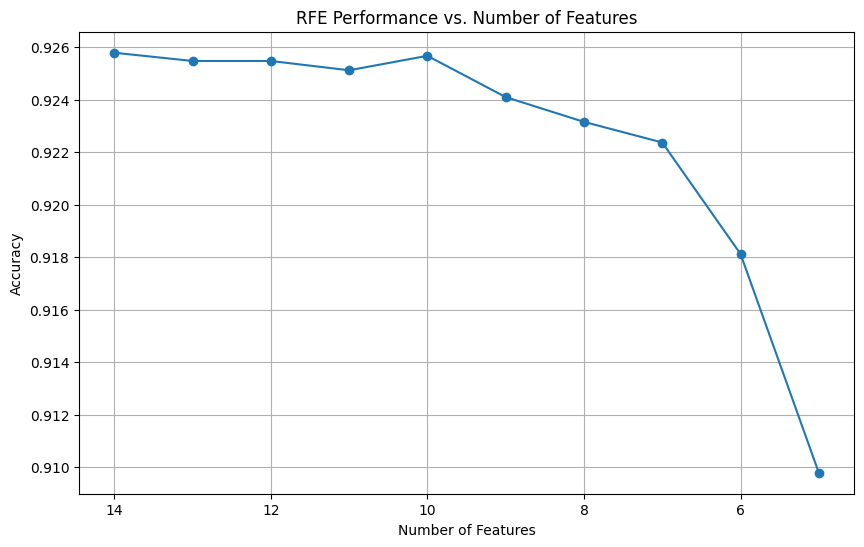


Transformed Features:
Start: 14 features → accuracy: 0.9262


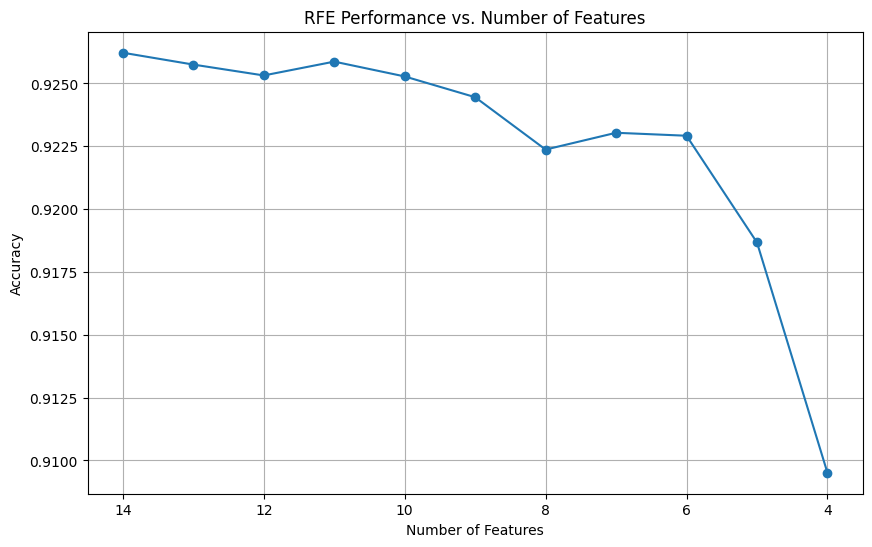


Combined Features:
Start: 23 features → accuracy: 0.9255


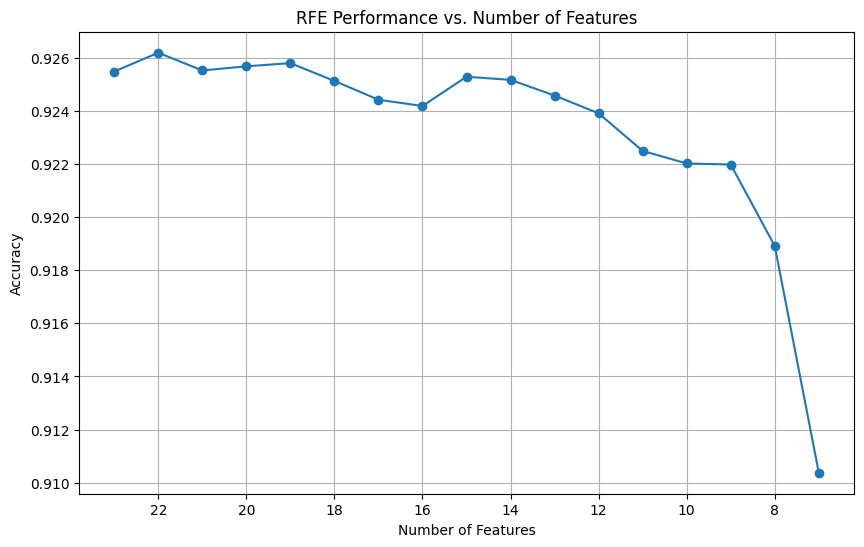

In [ ]:
print("Original Features:")
best_score_1, best_features_1 = shap_rfe(df[features_1], df[target], cv)

print("\nTransformed Features:")
best_score_2, best_features_2 = shap_rfe(df[features_2], df[target], cv)

print("\nCombined Features:")
best_score_3, best_features_3 = shap_rfe(df[features_3], df[target], cv)

In [ ]:
print("Original features:")
print(f"features: {best_features_1}")
print(f"performance: {best_score_1}")

print("\nTransformed features:")
print(f"features: {best_features_2}")
print(f"performance: {best_score_2}")

print("\nCombined features:")
print(f"features: {best_features_3}")
print(f"performance: {best_score_3}")

Original features:
features: ['user_edit_count', 'user_distinct_pages', 'user_warns', 'num_recent_edits', 'num_recent_reversions', 'num_edits_5d_before', 'account_age', 'word_count_added', 'word_count_deleted', 'vandalism_score', 'comment_empty', 'is_IP', 'current_minor', 'is_person']
performance: 0.9257907046972988

Transformed features:
features: ['vandalism_score', 'comment_empty', 'is_IP', 'current_minor', 'is_person', 'log_user_edit_count', 'log_user_distinct_pages', 'log_user_warns', 'log_num_recent_edits', 'log_num_recent_reversions', 'log_num_edits_5d_before', 'log_account_age', 'log_word_count_added', 'log_word_count_deleted']
performance: 0.9262232569325788

Combined features:
features: ['user_edit_count', 'user_distinct_pages', 'user_warns', 'num_recent_reversions', 'num_edits_5d_before', 'account_age', 'word_count_added', 'word_count_deleted', 'vandalism_score', 'comment_empty', 'is_IP', 'current_minor', 'is_person', 'log_user_edit_count', 'log_user_distinct_pages', 'log_us

In [ ]:
print("Original features:")
train_params_1, best_score_1 = train(
    df[best_features_1], df[target], cv, scoring="accuracy"
)

print("\nTransformed features:")
train_params_2, best_score_2 = train(
    df[best_features_2], df[target], cv, scoring="accuracy"
)

print("\nCombined features:")
train_params_3, best_score_3 = train(
    df[best_features_3], df[target], cv, scoring="accuracy"
)

Original features:
Baseline accuracy score: 0.9258
Optuna Optimization Results
Best Accuracy: 0.9274816750707883
Best hyperparameters: {'depth': 4, 'l2_leaf_reg': 9.857007262387562, 'learning_rate': 0.03230944241554112, 'iterations': 618, 'subsample': 0.9534263937618307, 'random_strength': 0.6227864572044912, 'bagging_temperature': 0.19631449889622685, 'border_count': 47}

Transformed features:
Baseline accuracy score: 0.9262
Optuna Optimization Results
Best Accuracy: 0.9268131655679636
Best hyperparameters: {'depth': 6, 'l2_leaf_reg': 0.16663730965211285, 'learning_rate': 0.027327540458847114, 'iterations': 613, 'subsample': 0.7492643319681781, 'random_strength': 0.33595345346710753, 'bagging_temperature': 0.3842657215024038, 'border_count': 106}

Combined features:
Baseline accuracy score: 0.9262
Optuna Optimization Results
Best Accuracy: 0.9273637737696285
Best hyperparameters: {'depth': 6, 'l2_leaf_reg': 6.429150795294775, 'learning_rate': 0.024592135180950783, 'iterations': 799, '